In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font="sans-serif", rc={"axes.grid": True, "grid.color": "gray", "grid.alpha": 0.5})

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [27]:
data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

In [28]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [29]:
data.rename(columns=dict(map(lambda name:(name,'_'.join(name.split(' '))), data.columns.to_list())), inplace=True)

In [30]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [31]:
X = data.drop(columns=['quality'], axis=1)
y = data.loc[:,'quality']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


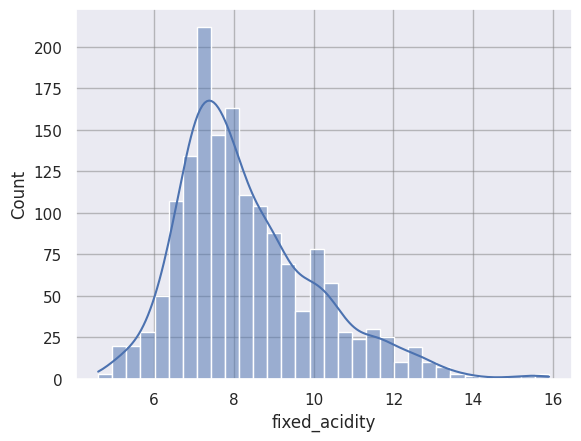

In [32]:
sns.histplot(data=X, x='fixed_acidity', kde=True)
plt.show()

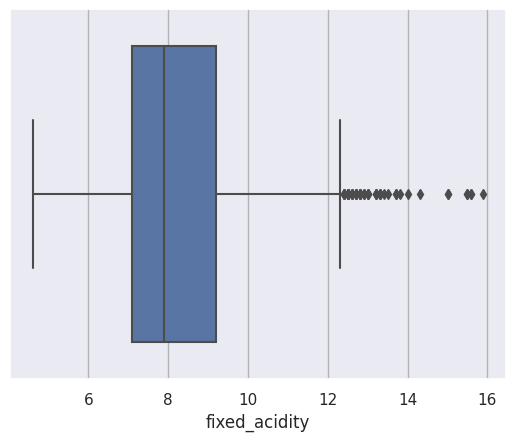

In [33]:
sns.boxplot(data=X, x='fixed_acidity')
plt.show()

In [35]:
def split_outliers(df: pd.DataFrame, col:str):
    q1,q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    iqr = q3-q1
    upper_tail = q3 + 1.5*iqr
    lower_tail = q1 - 1.5*iqr
    upper = df[col]>upper_tail
    lower = df[col]<lower_tail
    outliers_mask = upper|lower
    
    outliers = df.loc[outliers_mask, col]
    non_outliers = df.loc[~outliers_mask, col]
    
    ax=sns.scatterplot(x=outliers, y=y[outliers.index], color='red', alpha=0.65, label='Outliers')
    sns.scatterplot(x=non_outliers, y=y[non_outliers.index], color='green', alpha=0.35, ax=ax, label='Non-outliers')
    plt.legend()
    plt.show()
    
    return (outliers, non_outliers)

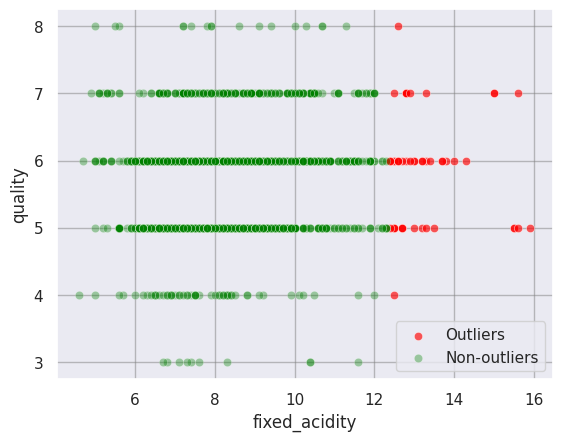

In [36]:
outliers,non_outliers = split_outliers(X, 'fixed_acidity')